# Image classifier

In [4]:
import os
import random
from collections import defaultdict
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.optim as optim
import torchvision.models as models
from PIL import Image
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_recall_fscore_support,
)
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm


In [2]:
# If using Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set up

In [5]:
def split_dataset(dataset_dir: str, train_ratio: float = 0.7, val_ratio: float = 0.15, test_ratio: float = 0.15, seed: int = 42) -> Dict[str, List[str]]:
    """
    Split dataset into train, validation, and test sets, keeping augmented images together.

    Parameters:
        dataset_dir (str): Path to the dataset directory with subdirectories for each class.
        train_ratio (float): Proportion of data to be used for training.
        val_ratio (float): Proportion of data to be used for validation.
        test_ratio (float): Proportion of data to be used for testing.
        seed (int): Random seed for reproducibility.

    Returns:
        Dict[str, List[str]]: Dictionary with lists of file paths for 'train', 'val', and 'test' sets.
    """
    random.seed(seed)
    assert train_ratio + val_ratio + test_ratio == 1, "Ratios must sum to 1"

    # Group images by base filename
    grouped_images = defaultdict(list)
    for root, _, files in os.walk(dataset_dir):
        for file in files:
            if file.endswith('.jpg'):
                base_filename = file.split('_aug')[0].split('.')[0]
                grouped_images[base_filename].append(os.path.join(root, file))

    # Convert grouped images to a list for random shuffling
    image_groups = list(grouped_images.values())
    random.shuffle(image_groups)

    # Calculate the number of samples for each set
    total_groups = len(image_groups)
    train_count = int(train_ratio * total_groups)
    val_count = int(val_ratio * total_groups)

    # Split the data
    train_set = [img for group in image_groups[:train_count] for img in group]
    val_set = [img for group in image_groups[train_count:train_count + val_count] for img in group]
    test_set = [img for group in image_groups[train_count + val_count:] for img in group]

    return {
        'train': train_set,
        'val': val_set,
        'test': test_set
    }

# Custom Dataset class to handle split file lists
class CustomImageDataset(Dataset):
    def __init__(self, file_paths: List[str], transform=None):
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        # Extract class label from the directory name (last part of the path before the file)
        label = int(os.path.basename(os.path.dirname(img_path)).split('_')[-1])
        return image, label

image_x = 240
image_y = 320

# Define transforms
transform = transforms.Compose([
    transforms.Resize((image_x, image_y)),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Use the function to split dataset
split_paths = split_dataset('/content/drive/MyDrive/SmallDataset/augmentedShoesSet/augmentedShoesSet',
                            train_ratio=0.7, val_ratio=0.15, test_ratio=0.15)

# Create datasets for each split
train_dataset = CustomImageDataset(split_paths['train'], transform=transform)
val_dataset = CustomImageDataset(split_paths['val'], transform=transform)
test_dataset = CustomImageDataset(split_paths['test'], transform=transform)

# Create data loaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Print the number of images in each set
print(f"Number of images in the training set: {len(train_dataset)}")
print(f"Number of images in the validation set: {len(val_dataset)}")
print(f"Number of images in the test set: {len(test_dataset)}")

Number of images in the training set: 1403
Number of images in the validation set: 300
Number of images in the test set: 295


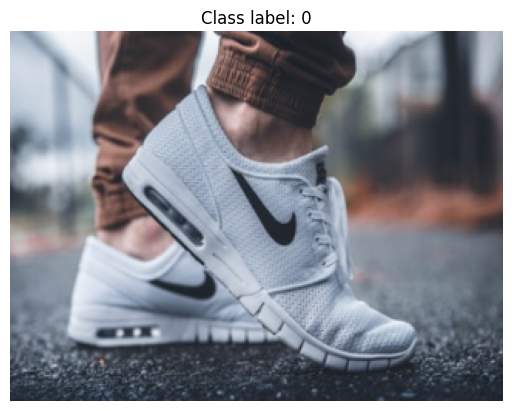

In [9]:
# Example: Display an image in the training set
image, label = train_dataset[1]
plt.imshow(image.permute(1, 2, 0))  # permute to move channels to the last dimension
plt.title(f"Class label: {label}")
plt.axis('off')
plt.show()

In [ ]:
# Get cpu, cuda, or mps device for training
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class CustomResNet(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomResNet, self).__init__()
        # Load a pretrained ResNet18 model
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Replace the final fully connected layer
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)

        # Add softmax layer
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.resnet(x)
        return self.softmax(x)

# Create an instance of your custom model
model = CustomResNet(num_classes=3)

Using cuda device


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s]


In [ ]:
# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer choice 1: Adam (recommended for faster convergence)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Define the number of epochs, early stopping criteria, and minimal loss threshold
num_epochs = 5
patience = 2  # Number of epochs to wait for improvement
min_loss_threshold = 0.05  # Define a threshold for minimal loss
best_loss = float("inf")  # Initialize best validation loss with infinity
early_stop_counter = 0  # Counter for early stopping

## Training

In [ ]:
# Initialize lists to store losses for plotting
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0  # To keep track of the loss

    # Initialize tqdm for the current epoch
    progress_bar = tqdm(
        train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"
    )

    for inputs, labels in progress_bar:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = loss_fn(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        # Update running loss and set description for tqdm
        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss / len(train_dataloader))

    # Calculate average training loss for the epoch
    avg_train_loss = running_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)  # Store training loss for plotting

    # Stop training if the loss is below the threshold
    if avg_train_loss < min_loss_threshold:
        print(f"\nStopping early as the training loss reached {avg_train_loss:.4f}")
        break

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_dataloader:  # Use validation dataloader here
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)  # Average validation loss
    val_losses.append(avg_val_loss)  # Store validation loss for plotting
    print(f"Validation Loss: {avg_val_loss:.4f}")

    # Early stopping check
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        early_stop_counter = 0  # Reset counter if loss improves
        torch.save(model.state_dict(), "best_model.pth")  # Save the best model
    else:
        early_stop_counter += 1
        print(f"No improvement for {early_stop_counter} epochs")

    if early_stop_counter >= patience:
        print("Early stopping triggered")
        break  # Stop training

# Test phase (Final evaluation after training is complete)
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_dataloader:  # Use test dataloader for final evaluation
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_dataloader)  # Average test loss
print(f"Test Loss: {avg_test_loss:.4f}")

# Save the final trained model
torch.save(model.state_dict(), "/content/drive/MyDrive/SmallDataset/shoesModelWithClean_291024.pth")

Epoch 1/5: 100%|██████████| 44/44 [15:15<00:00, 20.81s/batch, loss=0.69]


Validation Loss: 0.5942


Epoch 2/5: 100%|██████████| 44/44 [05:20<00:00,  7.29s/batch, loss=0.568]


Validation Loss: 0.5744


Epoch 3/5: 100%|██████████| 44/44 [05:23<00:00,  7.34s/batch, loss=0.56]


Validation Loss: 0.5802
No improvement for 1 epochs


Epoch 4/5: 100%|██████████| 44/44 [05:24<00:00,  7.38s/batch, loss=0.556]


Validation Loss: 0.5683


Epoch 5/5: 100%|██████████| 44/44 [05:20<00:00,  7.27s/batch, loss=0.555]


Validation Loss: 0.5705
No improvement for 1 epochs
Test Loss: 0.6061


Overall Accuracy: 0.9390

Metrics for class 'Shoes':
Precision: 0.9636
Recall: 0.9381
F1-score: 0.9507

Metrics for class 'Slippers':
Precision: 0.9043
Recall: 0.9551
F1-score: 0.9290

Metrics for class 'None':
Precision: 0.9451
Recall: 0.9247
F1-score: 0.9348


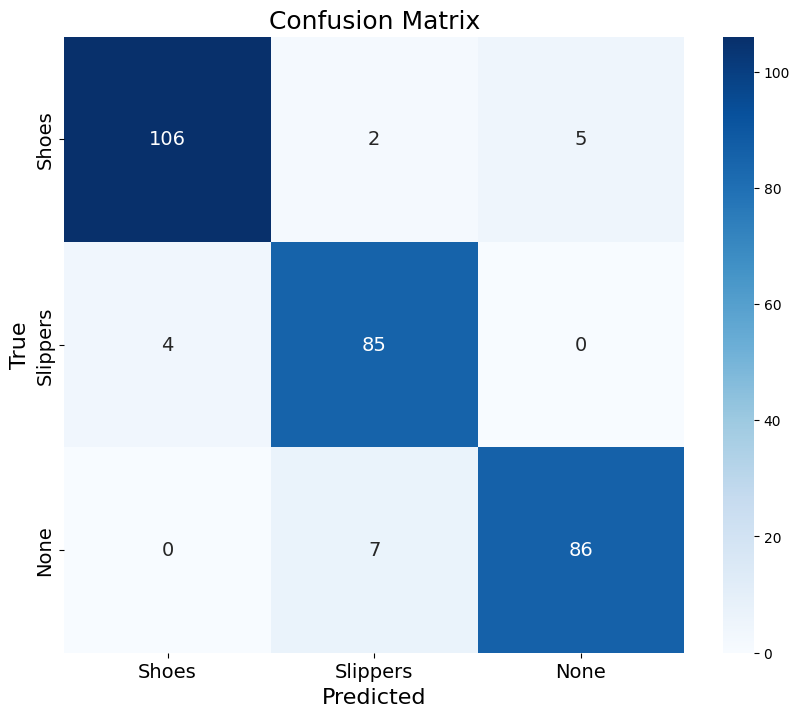

In [ ]:
# Define class names
class_names = ["Shoes", "Slippers", "None"]

# Move model to device (e.g., cuda or cpu)
model = model.to(device)

# Set the model to evaluation mode
model.eval()

# Lists to store true labels and predictions
all_labels = []
all_preds = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)  # Move inputs to device
        labels = labels.to(device)  # Move labels to device

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Get predicted class

        # Store labels and predictions
        all_labels.extend(labels.cpu().numpy())  # Move to CPU and convert to numpy
        all_preds.extend(preds.cpu().numpy())    # Same for predictions

# Convert labels and predictions to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Calculate overall accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Overall Accuracy: {accuracy:.4f}")

# Calculate precision, recall, and F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)

# Print metrics for each class
for i, class_name in enumerate(class_names):
    print(f"\nMetrics for class '{class_name}':")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1-score: {f1[i]:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix with larger text
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size": 14})  # Increase text size for annotations
plt.xlabel('Predicted', fontsize=16)  # Increase font size for x-axis label
plt.ylabel('True', fontsize=16)       # Increase font size for y-axis label
plt.title('Confusion Matrix', fontsize=18)  # Increase font size for title
plt.xticks(fontsize=14)  # Increase font size for x-tick labels
plt.yticks(fontsize=14)  # Increase font size for y-tick labels
plt.show()